In [2]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

2023-05-19 04:11:47.605828: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 04:11:48.153972: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


SIR sem fator de normalização.
$$\ \dot{S} = - \beta I S$$
$$\ \dot{I} = \beta I S - \gamma I$$
$$\ \dot{R} = - \gamma I S$$

In [3]:
# 0 para 160
t = np.linspace(0, 160, 161)

beta = 0.2  # Infection rate
gamma = 0.1  # Recovery rate

nn_input = np.zeros((100 * (len(t) - 1), 3))
nn_output = np.zeros_like(nn_input)


def sir_deriv(s_i_r, t0, beta=beta, gamma=gamma):
    S, I, R = s_i_r
    N = S + I + R
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

# random int values between 1000 and 2000
s = np.random.randint(1000, 2000, size=100)
# random int values between 200 and 300
i = np.random.randint(100, 200, size=100)
# random int values between 0 and 100
r = np.random.randint(0, 50, size=100)
x0 = np.array([s, i, r]).T
x0

array([[1647,  119,   27],
       [1412,  184,    3],
       [1942,  119,    2],
       [1612,  117,    0],
       [1484,  169,    8],
       [1189,  140,   11],
       [1366,  186,    4],
       [1714,  183,   32],
       [1745,  161,   16],
       [1312,  192,   29],
       [1984,  108,   10],
       [1548,  144,   27],
       [1162,  117,   17],
       [1068,  117,    9],
       [1108,  174,   28],
       [1336,  179,   19],
       [1912,  193,   18],
       [1808,  183,   37],
       [1434,  110,   18],
       [1139,  177,   14],
       [1018,  183,   37],
       [1761,  146,   13],
       [1434,  157,    9],
       [1554,  180,    6],
       [1133,  185,   47],
       [1981,  144,   37],
       [1380,  153,   17],
       [1205,  124,   32],
       [1812,  103,   14],
       [1130,  107,   15],
       [1312,  169,   26],
       [1020,  196,   41],
       [1387,  108,   43],
       [1945,  163,   11],
       [1584,  193,   38],
       [1807,  132,   36],
       [1122,  177,   49],
 

In [4]:
x_t = np.asarray([integrate.odeint(sir_deriv, x0_j, t) for x0_j in x0])
x_t.shape

(100, 161, 3)

In [5]:
for j in range(100):
    nn_input[j * (len(t) - 1):(j + 1) * (len(t) - 1), :] = x_t[j, :-1, :]
    nn_output[j * (len(t) - 1):(j + 1) * (len(t) - 1), :] = x_t[j, 1:, :]
nn_input.shape

(16000, 3)

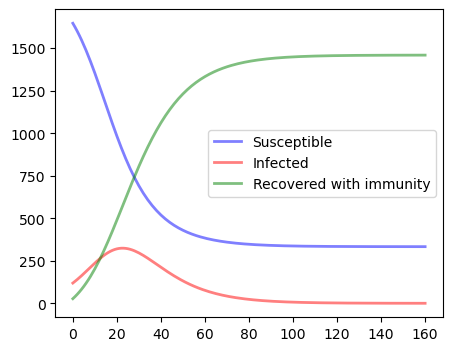

In [6]:
# plot of trajectory 0
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, x_t[0, :, 0], 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, x_t[0, :, 1], 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, x_t[0, :, 2], 'g', alpha=0.5, lw=2, label='Recovered with immunity')
plt.legend()
plt.show()

POSSÍVEL PROBLEMA: curva muito acentuada no início.

In [7]:
# Normalization
nn_input = nn_input / 1000
nn_output = nn_output / 1000

In [8]:
print(nn_input.shape)
print(nn_output.shape)
# Reshape
nn_input = nn_input.reshape(100, 160, 3)
nn_output = nn_output.reshape(100, 160, 3)
nn_input

(16000, 3)
(16000, 3)


array([[[1.64700000e+00, 1.19000000e-01, 2.70000000e-02],
        [1.62436345e+00, 1.29229498e-01, 3.94070565e-02],
        [1.60016471e+00, 1.39972265e-01, 5.28630230e-02],
        ...,
        [3.33179419e-01, 1.87037443e-04, 1.45963354e+00],
        [3.33172682e-01, 1.75646406e-04, 1.45965167e+00],
        [3.33166355e-01, 1.64948990e-04, 1.45966870e+00]],

       [[1.41200000e+00, 1.84000000e-01, 3.00000000e-03],
        [1.37865027e+00, 1.98239933e-01, 2.21097937e-02],
        [1.34367469e+00, 2.12670932e-01, 4.26543758e-02],
        ...,
        [2.68335964e-01, 7.61909727e-05, 1.33058785e+00],
        [2.68333490e-01, 7.12935465e-05, 1.33059522e+00],
        [2.68331175e-01, 6.67108982e-05, 1.33060211e+00]],

       [[1.94200000e+00, 1.19000000e-01, 2.00000000e-03],
        [1.91872679e+00, 1.29836893e-01, 1.44363129e-02],
        [1.89368144e+00, 1.41329314e-01, 2.79892433e-02],
        ...,
        [3.81123527e-01, 2.33327952e-04, 1.68164315e+00],
        [3.81115172e-01, 2.19

In [9]:
net = keras.models.Sequential()
net.add(layers.LSTM(10, input_shape=(nn_input.shape[1], nn_input.shape[2])))
net.add(layers.Dense(nn_input.shape[2]))
net.compile(loss='mean_squared_error', optimizer='adam')

2023-05-19 04:11:49.321752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-19 04:11:49.342013: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-19 04:11:49.342073: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-19 04:11:49.347171: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-19 04:11:49.347253: I tensorflow/compile

In [10]:
History = net.fit(nn_input, nn_output, epochs=10, batch_size=32)

Epoch 1/10


2023-05-19 04:11:50.763179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-19 04:11:50.765535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-19 04:11:50.766878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

InvalidArgumentError: Graph execution error:

Detected at node 'mean_squared_error/SquaredDifference' defined at (most recent call last):
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_20871/1586783711.py", line 1, in <module>
      History = net.fit(nn_input, nn_output, epochs=10, batch_size=32)
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/keras/engine/training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/keras/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/keras/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/daniel/miniconda3/envs/tcc/lib/python3.9/site-packages/keras/losses.py", line 1470, in mean_squared_error
      return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)
Node: 'mean_squared_error/SquaredDifference'
required broadcastable shapes
	 [[{{node mean_squared_error/SquaredDifference}}]] [Op:__inference_train_function_3132]

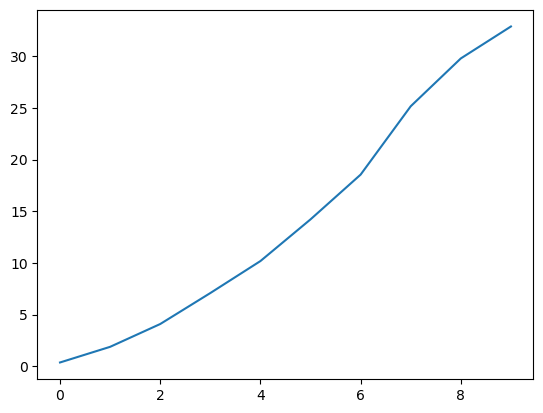

In [ ]:
plt.plot(History.history['loss'])

In [ ]:
# 2 casos testes
num_traj = 2

ynn = np.zeros((num_traj, len(t), 3))
s_teste = np.random.randint(10000, 20000, size=num_traj)
i_teste = np.random.randint(1000, 2000, size=num_traj)
r_teste = np.random.randint(0, 1000, size=num_traj)
ynn[:, 0, :] = np.array([s_teste, i_teste, r_teste]).T
for jj, tval in enumerate(t[:-1]):
    ynn[:, jj+1, :] = net.predict(ynn[:, jj, :], verbose=1)

1/1 [==============================] - 0s 14ms/step


In [ ]:
# solve ODE, the two trajectories
y_t_1 = integrate.odeint(sir_deriv, ynn[0, 0, :], t)
y_t_2 = integrate.odeint(sir_deriv, ynn[1, 0, :], t)
print(y_t_1)
print(y_t_2)

[[ 1.52170000e+04  1.89900000e+03  7.09000000e+02]
 [ 6.91502276e-15  1.58800225e+04  1.94497748e+03]
 [-4.26175280e-15  1.47325874e+04  3.09241255e+03]
 ...
 [-7.85458663e-14 -5.50189865e-11  1.78250000e+04]
 [-7.85458663e-14 -5.48515266e-11  1.78250000e+04]
 [-7.85458663e-14 -5.46840667e-11  1.78250000e+04]]
[[ 1.32280000e+04  1.49800000e+03  6.46000000e+02]
 [ 7.16006038e-15  1.36627458e+04  1.70925421e+03]
 [-5.43008348e-15  1.26755234e+04  2.69647660e+03]
 ...
 [ 3.72039467e-12 -3.63264508e-11  1.53720000e+04]
 [ 3.72039467e-12 -3.62355602e-11  1.53720000e+04]
 [ 3.72039467e-12 -3.61446696e-11  1.53720000e+04]]


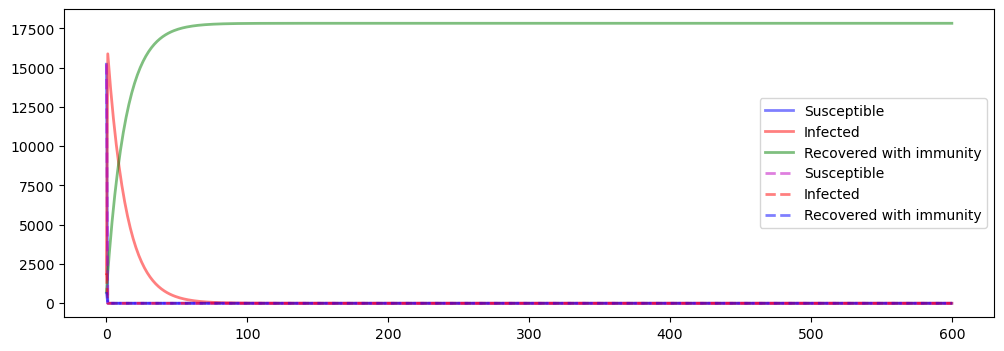

In [ ]:
# plot y_t_1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111, axisbelow=True)
# Calculated
ax.plot(t, y_t_1[:, 0], 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, y_t_1[:, 1], 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, y_t_1[:, 2], 'g', alpha=0.5, lw=2, label='Recovered with immunity')
# Predicted (plot with dotted lines)
ax.plot(t, ynn[0, :, 0], 'm--', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, ynn[0, :, 1], 'r--', alpha=0.5, lw=2, label='Infected')
ax.plot(t, ynn[0, :, 2], 'b--', alpha=0.5, lw=2, label='Recovered with immunity')
plt.legend()
plt.show()

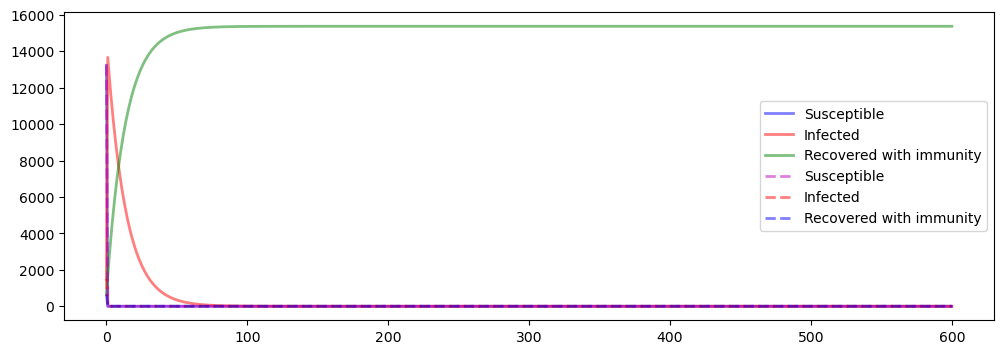

In [ ]:
# plot y_t_2
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, y_t_2[:, 0], 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, y_t_2[:, 1], 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, y_t_2[:, 2], 'g', alpha=0.5, lw=2, label='Recovered with immunity')
# Predicted (plot with dotted lines)
ax.plot(t, ynn[1, :, 0], 'm--', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, ynn[1, :, 1], 'r--', alpha=0.5, lw=2, label='Infected')
ax.plot(t, ynn[1, :, 2], 'b--', alpha=0.5, lw=2, label='Recovered with immunity')
plt.legend()
plt.show()